# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
from __future__ import print_function
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt



%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
print ("done")

done


## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print ("setup done\n")

setup done



## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])
print ("done here")

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [5]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################

best_lr = None
best_reg = None

range_lr = np.linspace(learning_rates[0],learning_rates[1],5)
range_reg = np.linspace(regularization_strengths[0],regularization_strengths[1],5)

print ("strating loop ! This may take a while\n\n")
# loop through all the combinations
for cur_lr in range_lr: #go over the learning rates
    for cur_reg in range_reg:#go over the regularization strength
        # initiate linear classifier with hyperparameters
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, learning_rate=cur_lr, reg=cur_reg,num_iters=1600, verbose=True)
        
        # Training
        y_pred = svm.predict(X_train_feats)
        train_accuracy = np.mean(np.equal(y_train, y_pred, dtype=float))


        # Validation
        y_pred = svm.predict(X_val_feats)  
        val_accuracy = np.mean(np.equal(y_val, y_pred, dtype=float))
  
        results[(cur_lr, cur_reg)] = (train_accuracy, val_accuracy)
  
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm
            best_lr = cur_lr
            best_reg = cur_reg





# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

strating loop ! This may take a while


X shape   (49000, 155)
iteration 0 / 1600: loss 47.650660
iteration 100 / 1600: loss 47.277811
iteration 200 / 1600: loss 46.892079
iteration 300 / 1600: loss 46.513451
iteration 400 / 1600: loss 46.136074
iteration 500 / 1600: loss 45.771115
iteration 600 / 1600: loss 45.391001
iteration 700 / 1600: loss 45.050272
iteration 800 / 1600: loss 44.675026
iteration 900 / 1600: loss 44.313301
iteration 1000 / 1600: loss 43.957297
iteration 1100 / 1600: loss 43.626499
iteration 1200 / 1600: loss 43.275254
iteration 1300 / 1600: loss 42.937266
iteration 1400 / 1600: loss 42.598399
iteration 1500 / 1600: loss 42.268559
X shape   (49000, 155)
iteration 0 / 1600: loss 132.244065
iteration 100 / 1600: loss 128.304558
iteration 200 / 1600: loss 124.504448
iteration 300 / 1600: loss 120.810138
iteration 400 / 1600: loss 117.210564
iteration 500 / 1600: loss 113.762904
iteration 600 / 1600: loss 110.403294
iteration 700 / 1600: loss 107.173281
iteration 800 / 

iteration 200 / 1600: loss 134.192374
iteration 300 / 1600: loss 90.716863
iteration 400 / 1600: loss 62.328986
iteration 500 / 1600: loss 43.804336
iteration 600 / 1600: loss 31.716825
iteration 700 / 1600: loss 23.822956
iteration 800 / 1600: loss 18.675258
iteration 900 / 1600: loss 15.316113
iteration 1000 / 1600: loss 13.119664
iteration 1100 / 1600: loss 11.690648
iteration 1200 / 1600: loss 10.755231
iteration 1300 / 1600: loss 10.145348
iteration 1400 / 1600: loss 9.747933
iteration 1500 / 1600: loss 9.487759
X shape   (49000, 155)
iteration 0 / 1600: loss 403.599774
iteration 100 / 1600: loss 236.502020
iteration 200 / 1600: loss 140.156982
iteration 300 / 1600: loss 84.611497
iteration 400 / 1600: loss 52.593245
iteration 500 / 1600: loss 34.132668
iteration 600 / 1600: loss 23.486387
iteration 700 / 1600: loss 17.353692
iteration 800 / 1600: loss 13.815103
iteration 900 / 1600: loss 11.775551
iteration 1000 / 1600: loss 10.600755
iteration 1100 / 1600: loss 9.923125
iteratio

In [7]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print("test accuracy :",test_accuracy)

test accuracy : 0.401


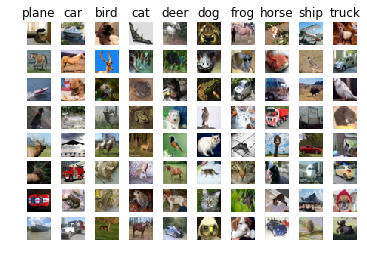

In [8]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

**Answer** :To be honest I am failing to find any common features amongst the misclassified images within each class. Perhaps this is a reflection of the quality of the design of the two layer network, maybe a deeper analysis on each learned feature.  

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [9]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [10]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################

# defaults

num_classes = 10

# hyperparameters
learning_rates = [1,1e-3]
regularization_strengths = [0, 1]
hidden_sizes = [100,800]
batch_sizes = [100,600]

# additional variables 
best_lr = None
best_reg = None
best_hidd = None
best_batch_size = None

# tune list of hyperparameters used
range_lr = np.linspace(learning_rates[0],learning_rates[1],6)
range_reg = np.linspace(regularization_strengths[0],regularization_strengths[1],3)
range_hs = [200,300,400,500,600,700]
range_bs = [200,300, 400]

best_val_acc = -1
print ("starting optimization, this may take a while :(")
for hs in range_hs:
    for lr in range_lr:
        for bs in range_bs:
            for rg in range_reg:
                print ('hs:', hs, 'lr:', lr, 'bs', bs, 'reg', rg)
                
                net = TwoLayerNet(input_dim, hs, output_size=num_classes)
                
                # train
                stats = net.train(X_train_feats, y_train, X_val_feats, y_val,num_iters=500,learning_rate=lr,reg=rg, batch_size=bs)
                # check validation accuracy
                val_acc = (net.predict(X_val_feats) == y_val).mean()
                
                #print ('hs:', hs, 'lr:', lr, 'bs', bs, 'reg', rg)
                print ('Validation accuracy: ', val_acc)
                
                # store optimal hyperparameters
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_net = net
                    best_lr = lr
                    best_reg = rg
                    best_hidd = hs
                    best_batch_size = bs
                    
print ("\n** best validation achieved during cross validation: " ,best_val_acc) 


starting optimization, this may take a while :(
hs: 200 lr: 1.0 bs 200 reg 0.0
Validation accuracy:  0.51
hs: 200 lr: 1.0 bs 200 reg 0.5
Validation accuracy:  0.119
hs: 200 lr: 1.0 bs 200 reg 1.0
Validation accuracy:  0.079
hs: 200 lr: 1.0 bs 300 reg 0.0
Validation accuracy:  0.543
hs: 200 lr: 1.0 bs 300 reg 0.5
Validation accuracy:  0.112
hs: 200 lr: 1.0 bs 300 reg 1.0
Validation accuracy:  0.078
hs: 200 lr: 1.0 bs 400 reg 0.0
Validation accuracy:  0.569
hs: 200 lr: 1.0 bs 400 reg 0.5
Validation accuracy:  0.079
hs: 200 lr: 1.0 bs 400 reg 1.0
Validation accuracy:  0.119
hs: 200 lr: 0.8002 bs 200 reg 0.0
Validation accuracy:  0.533
hs: 200 lr: 0.8002 bs 200 reg 0.5
Validation accuracy:  0.087
hs: 200 lr: 0.8002 bs 200 reg 1.0
Validation accuracy:  0.113
hs: 200 lr: 0.8002 bs 300 reg 0.0
Validation accuracy:  0.537
hs: 200 lr: 0.8002 bs 300 reg 0.5
Validation accuracy:  0.105
hs: 200 lr: 0.8002 bs 300 reg 1.0
Validation accuracy:  0.113
hs: 200 lr: 0.8002 bs 400 reg 0.0
Validation accur

Validation accuracy:  0.112
hs: 400 lr: 0.6004 bs 200 reg 0.0
Validation accuracy:  0.556
hs: 400 lr: 0.6004 bs 200 reg 0.5
Validation accuracy:  0.102
hs: 400 lr: 0.6004 bs 200 reg 1.0
Validation accuracy:  0.107
hs: 400 lr: 0.6004 bs 300 reg 0.0
Validation accuracy:  0.56
hs: 400 lr: 0.6004 bs 300 reg 0.5
Validation accuracy:  0.105
hs: 400 lr: 0.6004 bs 300 reg 1.0
Validation accuracy:  0.079
hs: 400 lr: 0.6004 bs 400 reg 0.0
Validation accuracy:  0.553
hs: 400 lr: 0.6004 bs 400 reg 0.5
Validation accuracy:  0.107
hs: 400 lr: 0.6004 bs 400 reg 1.0
Validation accuracy:  0.107
hs: 400 lr: 0.40059999999999996 bs 200 reg 0.0
Validation accuracy:  0.528
hs: 400 lr: 0.40059999999999996 bs 200 reg 0.5
Validation accuracy:  0.112
hs: 400 lr: 0.40059999999999996 bs 200 reg 1.0
Validation accuracy:  0.078
hs: 400 lr: 0.40059999999999996 bs 300 reg 0.0
Validation accuracy:  0.541
hs: 400 lr: 0.40059999999999996 bs 300 reg 0.5
Validation accuracy:  0.087
hs: 400 lr: 0.40059999999999996 bs 300 r

Validation accuracy:  0.105
hs: 600 lr: 0.40059999999999996 bs 400 reg 1.0
Validation accuracy:  0.113
hs: 600 lr: 0.20079999999999998 bs 200 reg 0.0
Validation accuracy:  0.518
hs: 600 lr: 0.20079999999999998 bs 200 reg 0.5
Validation accuracy:  0.087
hs: 600 lr: 0.20079999999999998 bs 200 reg 1.0
Validation accuracy:  0.078
hs: 600 lr: 0.20079999999999998 bs 300 reg 0.0
Validation accuracy:  0.519
hs: 600 lr: 0.20079999999999998 bs 300 reg 0.5
Validation accuracy:  0.119
hs: 600 lr: 0.20079999999999998 bs 300 reg 1.0
Validation accuracy:  0.112
hs: 600 lr: 0.20079999999999998 bs 400 reg 0.0
Validation accuracy:  0.497
hs: 600 lr: 0.20079999999999998 bs 400 reg 0.5
Validation accuracy:  0.087
hs: 600 lr: 0.20079999999999998 bs 400 reg 1.0
Validation accuracy:  0.087
hs: 600 lr: 0.001 bs 200 reg 0.0
Validation accuracy:  0.102
hs: 600 lr: 0.001 bs 200 reg 0.5
Validation accuracy:  0.105
hs: 600 lr: 0.001 bs 200 reg 1.0
Validation accuracy:  0.087
hs: 600 lr: 0.001 bs 300 reg 0.0
Valida

In [11]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

# winning hyperparameters
print ("best hypeparameters ->  hidden ", best_hidd, ' lr ', best_lr, ' bs', best_batch_size, ' reg  ', best_reg)
# add validation accuracy just for clarity for below inline question
val_acc = (best_net.predict(X_val_feats) == y_val).mean()
print ("Best net Validation accuracy :", val_acc)

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print("Test accuracy   ",test_acc)

best hypeparameters ->  hidden  600  lr  1.0  bs 400  reg   0.0
Best net Validation accuracy : 0.59
Test accuracy    0.578
